# https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/

In [1]:
# importing pandas as pd
import pandas as pd
  
# Creating the dataframe 
df = pd.DataFrame({"A":[12, 4, 5, None, 1],
                   "B":[None, 2, 54, 3, None],
                   "C":[20, 16, None, 3, 8],
                   "D":[14, 3, None, None, 6]})
  
# Print the dataframe
df

,A,B,C,D
0,12.0,NaN,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,NaN,NaN
3,NaN,3.0,3.0,NaN
4,1.0,NaN,8.0,6.0


# Fill in missing values using interpolation in PANDAS
# https://www.geeksforgeeks.org/python-pandas-dataframe-interpolate/

In [3]:
# to interpolate the missing values
df_interp = df.interpolate(method ='linear', limit_direction ='forward')
df_interp

,A,B,C,D
0,12.0,NaN,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,9.5,4.0
3,3.0,3.0,3.0,5.0
4,1.0,3.0,8.0,6.0


In [4]:
# to interpolate the missing values
df_interp_2 = df.interpolate(method ='linear', limit_direction ='backward', limit = 1)
df_interp_2

,A,B,C,D
0,12.0,2.0,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,9.5,NaN
3,3.0,3.0,3.0,5.0
4,1.0,NaN,8.0,6.0


# https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

data_unlabeled = pd.read_csv("data/unlabeled.csv")
x_unlabeled = data_unlabeled[["x1", "x2"]].values

In [44]:
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

In [45]:
def e_step(x, params):
    np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

In [46]:
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

In [47]:
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods


	phi: 0.4225810708365641
	mu_0: [1.00669857 1.00524928]
	mu_1: [-1.02855011 -0.99608097]
	sigma_0: [[0.70209932 0.13422222]
 [0.13422222 0.30360867]]
	sigma_1: [[0.37245288 0.32761436]
 [0.32761436 0.78888141]]
total steps:  40


<ipython-input-45-a60c4ae6ae29>:2: RuntimeWarning: divide by zero encountered in log
  np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
<ipython-input-45-a60c4ae6ae29>:5: RuntimeWarning: divide by zero encountered in log
  np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),


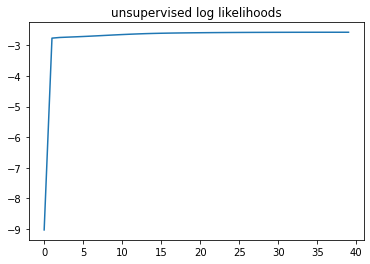

In [48]:
random_params = initialize_random_params()
unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
print("total steps: ", len(unsupervised_loglikelihoods))
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")
plt.show()
#plt.close()